Loading required package: lattice
Loading required package: ggplot2
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'target' is not a factor"Warning message in preProcess.default(adultFixed2, method = c("center", "scale")):
"These variables have zero variances: workclass.."Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'Survived' is not a factor"

[1] 0.8268479

[1] 0.8193195

[1] 0.8387951

[1] 0.8058052

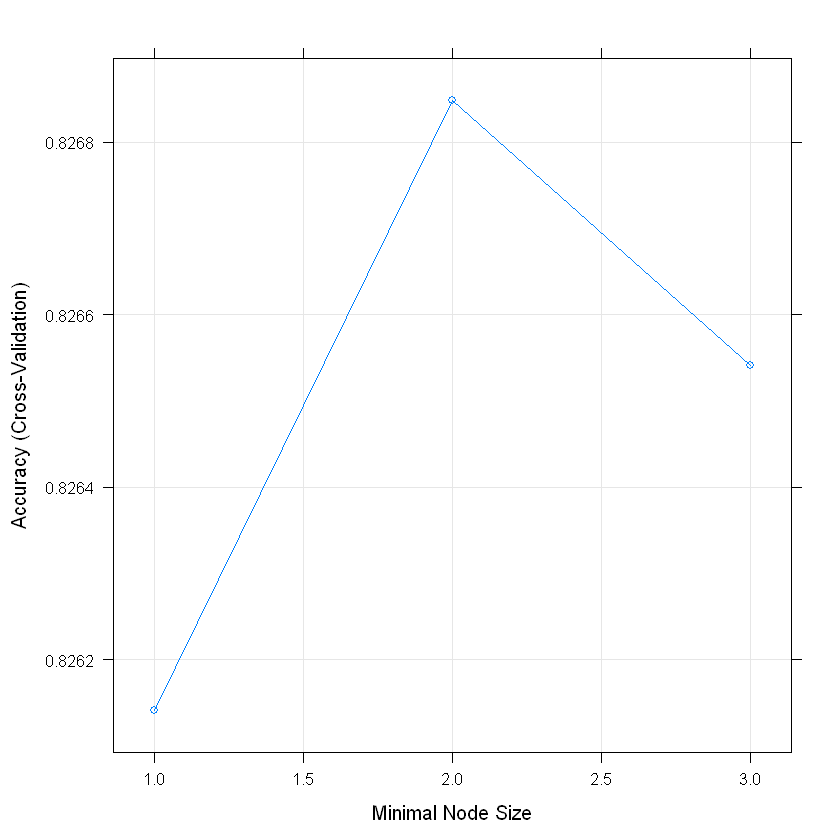

[1] 0.8514787

[1] 0.8462458

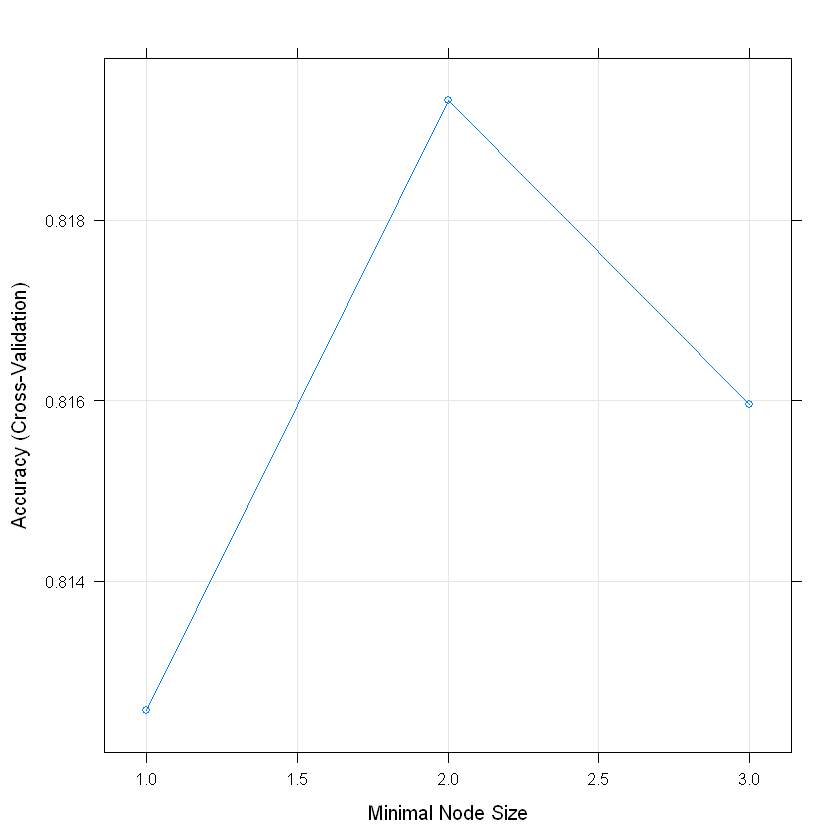

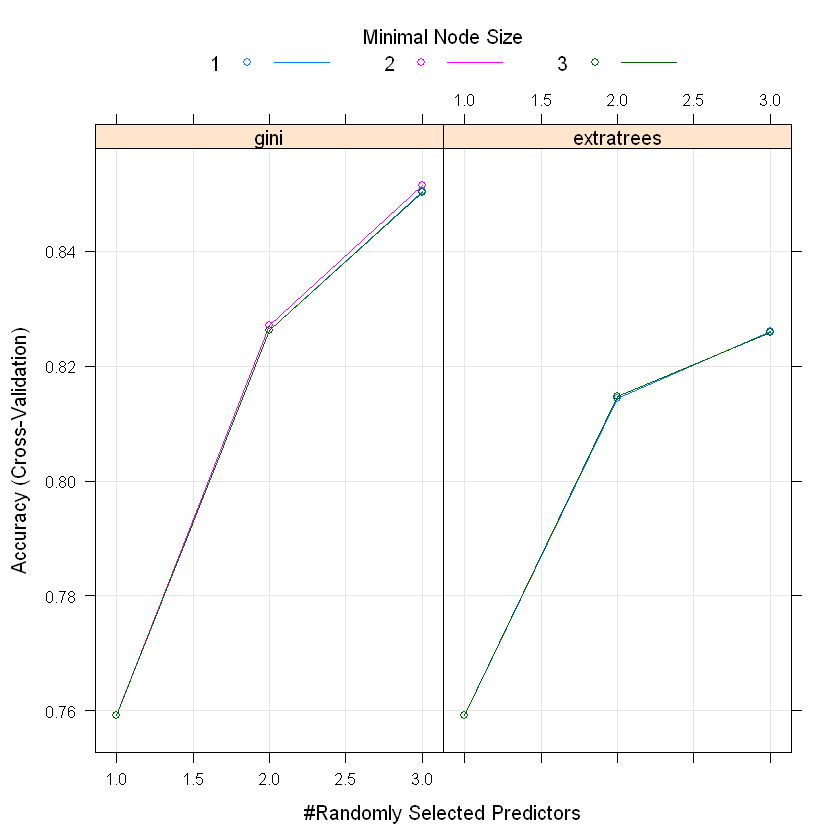

[1] 0.8476705

[1] 0.8469333

[1] 0.7967651

[1] 0.7946839

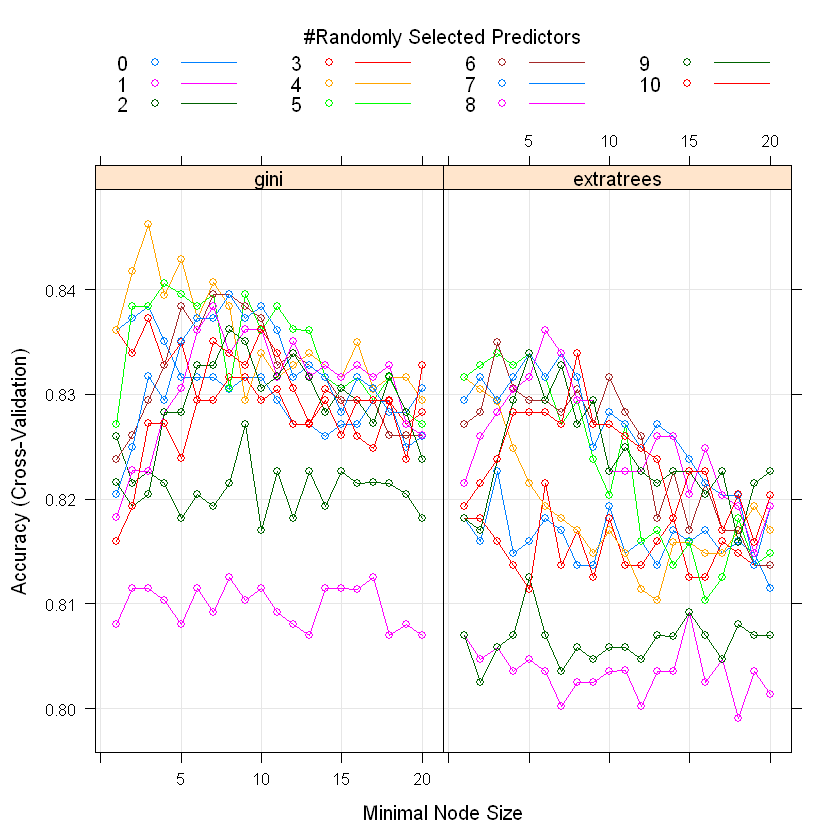

In [2]:
##1.	Preprocess the data so that it is ready to train predictive models.

library(caret)
library(glmnet)
adult = read.csv("adult.csv", header = FALSE)
names(adult) = c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
  "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
  "hours_per_week", "native_country", "target")


for(i in 1:ncol(adult)){
    adult[,i][adult[,i] == "?"] = NA
    mode = levels(adult[,i])[which.max(table(adult[,i]))]
    if(is.factor(adult[,i])){
      adult[,i][is.na(adult[,i])] = mode
    }
}

adultNAfix = preProcess(adult, method='medianImpute')
adultFixed = predict(adultNAfix, newdata = adult)
levels(adultFixed$education) = c("Gradeshool","Gradeschool","Gradeschool", "Gradeschool",
                                 "Gradeshool","Gradeshool","Gradeshool","Associates",
                                 "Associates", "Bachelors", "Post_Grad", "HS+", "Post_Grad",
                                 "Gradeschool","HS+", "HS+")
levels(adultFixed$occupation) = c("Misc", "Business", "Protection", "Labor", "Business",
                                  "Labor", "Labor", "Tech", "Misc", "Labor", "Misc",
                                  "Protection", "Business", "Tech", "Labor")
levels(adultFixed$native_country) = c("NA", "AFR", "NA", "AS", "SA", "NA", "NA", "SA", "NA",
                                      "EU", "EU", "EU", "EU", "NA", "NA", "EU", "NA", "AS",
                                      "EU", "AS", "AS", "EU", "EU", "NA", "AS", "AS", "NA",
                                      "NA", "NA", "SA", "AS", "EU", "EU", "NA", "EU",
                                      "AS", "AS", "AS", "NA", "NA", "AS", "EU")
dummies_model <- dummyVars(target ~ ., data=adultFixed)
adultFixed_mat <- predict(dummies_model, newdata = adultFixed)
adultFixed2 <- data.frame(adultFixed_mat)
adultFixed2$target <- adult$target
ScaleAndCenter <- preProcess(adultFixed2, method= c("center", "scale"))
FinalAdult <- predict(ScaleAndCenter, newdata = adultFixed2)



titanic = read.csv("titanic.csv")
titanic$PassengerId = NULL
titanic$Name = NULL
titanic$Ticket = NULL
titanic$Cabin = NULL
titanic$Survived = as.factor(titanic$Survived)
levels(titanic$Embarked) = c("S","C","Q","S")
titanicNAfix = preProcess(titanic, method='medianImpute')
titanicFixed = predict(titanicNAfix, newdata = titanic)

dummies_model2 <- dummyVars(Survived ~ ., data=titanicFixed)
titanicFixed_mat <- predict(dummies_model2, newdata = titanicFixed)
titanicFixed2 <- data.frame(titanicFixed_mat)
titanicFixed2$Survived <- titanic$Survived
ScaleAndCenter2 <- preProcess(titanicFixed2, method= c("center", "scale"))
FinalTitanic <- predict(ScaleAndCenter2, newdata = titanicFixed2)
FinalTitanic$Survived <- titanic$Survived

##2.	Train a random forest with 7-fold cross validation.  Report the accuracy of the forest. 

myGrid7a = expand.grid(mtry = 2, splitrule = c("gini"),
                     min.node.size = c(1:3))

model7a <- train(target~.,data = FinalAdult, method = "ranger", 
               trControl = trainControl(method ="cv", number = 7),
               tuneGrid = myGrid7a)
max(model7a$results$Accuracy)


myGrid7t = expand.grid(mtry = 2, splitrule = c("gini"),
                     min.node.size = c(1:3))

model7t <- train(Survived~.,data = FinalTitanic, method = "ranger", 
               trControl = trainControl(method ="cv", number = 7),
               tuneGrid = myGrid7t)
max(model7t$results$Accuracy)

##3.	Train a decision tree with 10-fold cross validation.  Report the accuracy. 


model10a <- train(target~.,data = FinalAdult, method = "rpart", 
               trControl = trainControl(method ="cv", number = 10))
max(model10a$results$Accuracy)



model10t <- train(Survived~.,data = FinalTitanic, method = "rpart", 
               trControl = trainControl(method ="cv", number = 10))
max(model10t$results$Accuracy)

###4.	What are the selection of the hyperparameters (mtry, splitrule, min.mode.size) in the random forest in 2? 

#Answer: Adult(mtry = 2, splitrule = gini, min.node.size = 2) Titanic(mtry = 2, splitrule = gini, min.node.size = 1)


##5.	Print out the plot of the random forest.

plot(model7a)
plot(model7t)

####6.	Tune the three hyperparameters of the random forest with mtry running all its possible values, splitrule running all its possible values (gini and extratrees) and min.node.size running from 1 to 20. Simplify this step and run on some of them

myGrid7a2 = expand.grid(mtry = c(1:3), splitrule = c("gini", "extratrees"),
                     min.node.size = c(1:3))

model7a2 <- train(target~.,data = FinalAdult, method = "ranger", 
               trControl = trainControl(method ="cv", number = 7),
               tuneGrid = myGrid7a2)
max(model7a2$results$Accuracy)


myGrid7t2 = expand.grid(mtry = c(1:ncol(FinalTitanic)-1), splitrule = c("gini", "extratrees"),
                     min.node.size = c(1:20))

model7t2 <- train(Survived~.,data = FinalTitanic, method = "ranger", 
               trControl = trainControl(method ="cv", number = 7),
               tuneGrid = myGrid7t2)
max(model7t2$results$Accuracy)

###7.	Print out the tuning plot of the random forest.  Does your tuned random forest in 6 achieve better accuracy than the default random forest in 2? 


plot(model7a2)
plot(model7t2)
# Yes the model with more tested hyperparameters should achieve higher accuracy, but it is not a guarantee due to randomness.


###8.	Compare the performances of the default glmnet model and a tuned glmnet model. Do you achieve better performance in the tuned glmnet model?

model7aglm <- train(target~.,data = FinalAdult, method = "glmnet", 
               trControl = trainControl(method ="cv", number = 7))
#adult non tuned glm
max(model7aglm$results$Accuracy)


myGrid7aglm2 = expand.grid(alpha = 0:1, lambda = seq(.000001, 1, 20))

model7aglm2 <- train(target~.,data = FinalAdult, method = "glmnet", 
               trControl = trainControl(method ="cv", number = 7),
               tuneGrid = myGrid7aglm2)
#adult tuned glm
max(model7aglm2$results$Accuracy)


model7tglm <- train(Survived~.,data = FinalTitanic, method = "glmnet", 
               trControl = trainControl(method ="cv", number = 7))
#titanic non tuned glm
max(model7tglm$results$Accuracy)


myGrid7tglm2 = expand.grid(alpha = 0:1, lambda = seq(.000001, 1, 20))

model7tglm2 <- train(Survived~.,data = FinalTitanic, method = "glmnet", 
               trControl = trainControl(method ="cv", number = 7),
               tuneGrid = myGrid7tglm2)
#titanic tuned glm
max(model7tglm2$results$Accuracy)


#They are showing roughly the same values as the default method, this is because the default method already covers the most relevant numbers hence making the extra tuning not add much to the project.